<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>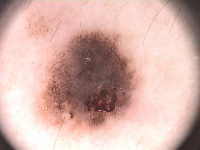</td><td>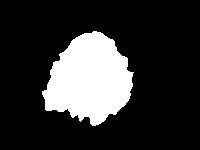</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2024-05-31 14:32:33--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2024-05-31 14:32:33--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0062dfae07c350164c368d90a4.dl.dropboxusercontent.com/cd/0/inline/CT-uQft0bFONT6tx703MSmvAIW-hpxFjLq7q6oxe0B-S_FAW1JWzHCMSA88WVFSU7OItv3hvGBeO6Rh_y8qJsksvhJSHF0Rq5lnJtCGMoQVr5trOgIdkRBeWrI5LqbLcXwA/file# [following]
--2024-05-31 14:32:34--  https://uc0062dfae07c350164c368d90a4.dl.dropboxusercontent.com/cd/0/inline/CT-uQft0bFONT6tx703MSmvAIW-hpxFjLq7q6oxe0B-S_FAW1JWzHCMSA88WVFSU7OItv3hvGBeO6Rh_y8qJsksvhJSHF0Rq5lnJtCGMoQVr5trOgI

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

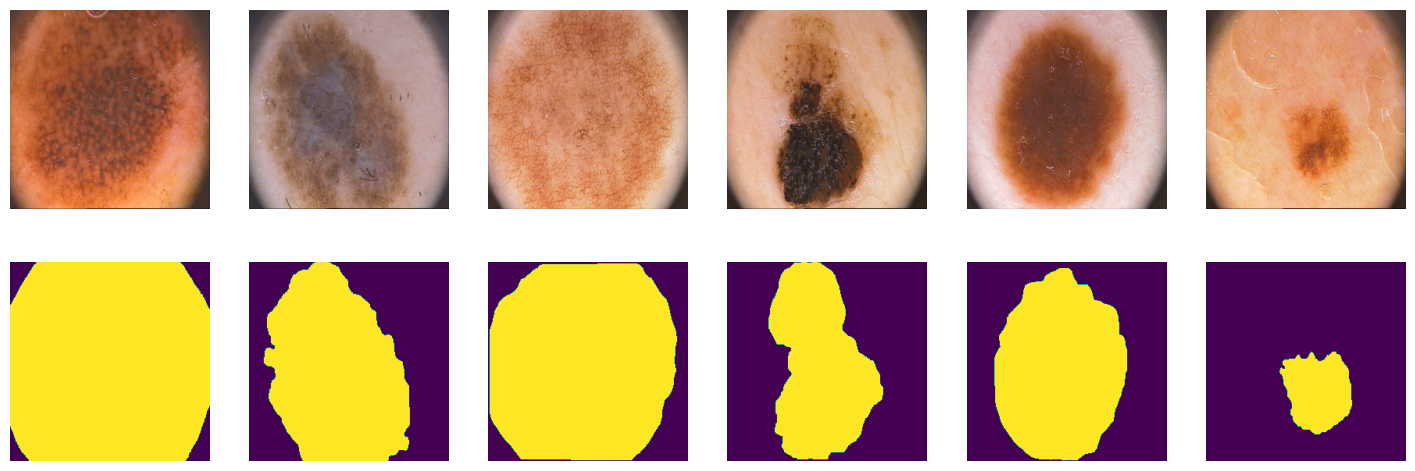

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

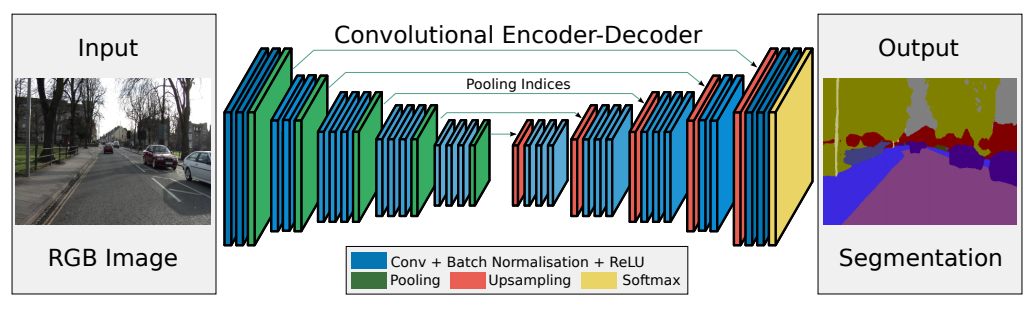

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import gc
from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.enc_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128


        self.enc_conv1_0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.enc_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64


        self.enc_conv2_0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.enc_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32


        self.enc_conv3_0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.enc_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16


        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 16 -> 8

        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 8 -> 16
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv3_0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.dec_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv2_0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.dec_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv1_0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.dec_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)# 128 -> 256
        self.dec_conv0_0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.dec_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, indices_0 = self.pool0(F.relu(self.enc_conv0_1(F.relu(self.enc_conv0_0(x))))) # 256 -> 128
        e1, indices_1 = self.pool1(F.relu(self.enc_conv1_1(F.relu(self.enc_conv1_0(e0))))) # 128 -> 64
        e2, indices_2 = self.pool2(F.relu(self.enc_conv2_1(F.relu(self.enc_conv2_1(F.relu(self.enc_conv2_0(e1))))))) # 64 -> 32
        e3, indices_3 = self.pool3(F.relu(self.enc_conv3_1(F.relu(self.enc_conv3_1(F.relu(self.enc_conv3_0(e2))))))) # 32 -> 16
        e4, indices_4 = self.pool4(F.relu(self.enc_conv4(F.relu(self.enc_conv4(F.relu(self.enc_conv4(e3))))))) # 16 -> 8

        # # bottleneck
        # b =

        # decoder
        d4 = F.relu(self.dec_conv4(F.relu(self.dec_conv4(F.relu(self.dec_conv4(self.upsample4(e4, indices_4)))))))
        d3 = F.relu(self.dec_conv3_1(F.relu(self.dec_conv3_1(F.relu(self.dec_conv3_0(self.upsample3(d4, indices_3)))))))
        d2 = F.relu(self.dec_conv2_1(F.relu(self.dec_conv2_1(F.relu(self.dec_conv2_0(self.upsample2(d3, indices_2)))))))
        d1 = F.relu(self.dec_conv1_1(F.relu(self.dec_conv1_0(self.upsample1(d2, indices_1)))))
        d0 = self.dec_conv0_1(F.relu(self.dec_conv0_0(self.upsample0(d1, indices_0))))    # no activation
        return d0

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = y_pred.to(device)
    y_real = y_real.to(device)
    return (y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val, Y_val = next(iter(data_val))
    train_loss = []
    val_loss = []
    iou_score = []
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in tqdm(data_tr):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)

        train_loss.append(avg_loss.item())
        toc = time()
        print('loss train: %f' % avg_loss)

        if scheduler is not None:
            scheduler.step(avg_loss)
        model.eval()
        X_val, Y_val = X_val.to(device), Y_val.to(device)
        Y_hat = model(X_val)
        loss = loss_fn(Y_val, Y_hat)
        Y_hat = torch.sigmoid(Y_hat)
        val_loss.append(loss.item()/len(data_val))

        iou = score_model(model, iou_pytorch, data_val)
        iou_score.append(iou)

        print('loss valid: %f' % val_loss[-1])

        # сохраняем веса лучшей модели
        if val_loss[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss[-1]))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = val_loss[-1]

        Y_hat, X_val, Y_val = Y_hat.detach().to('cpu'), X_val.to('cpu'), Y_val.to('cpu')

        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    # загружаем модель с лучшими весами
    model.load_state_dict(torch.load('model.pt'))
    print('loading best model state')

    # выводим график обучения
    plt.plot(range(epochs), val_loss)
    plt.title('val_loss')
    plt.show()

    plt.plot(range(epochs), train_loss)
    plt.title('train_loss')
    plt.show()

    return val_loss, train_loss, iou_score

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            Y_pred = model(X_batch)
            Y_pred = (torch.sigmoid(Y_pred) >= 0.5)
            scores += metric(Y_pred, Y_label).mean().item()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

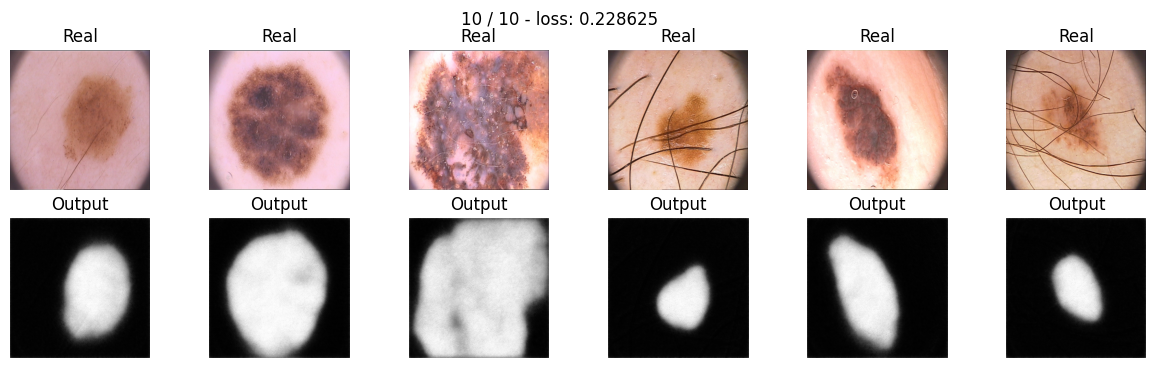

loading best model state


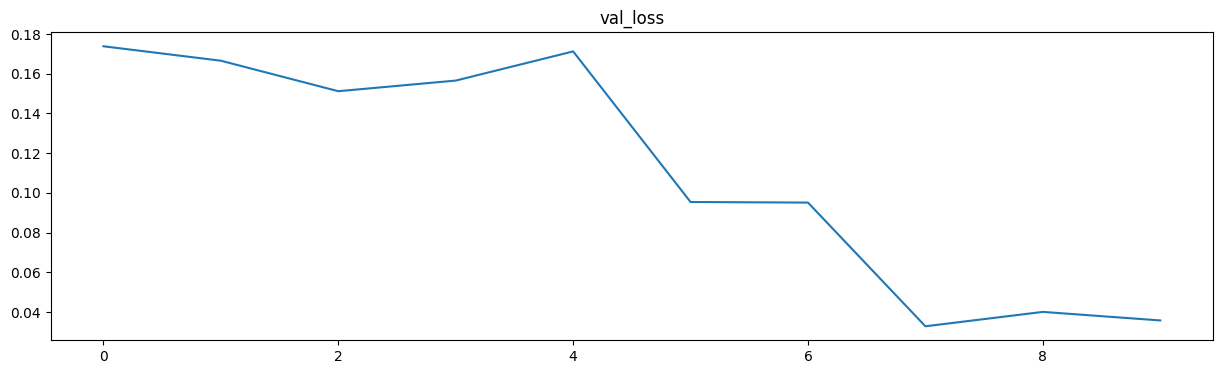

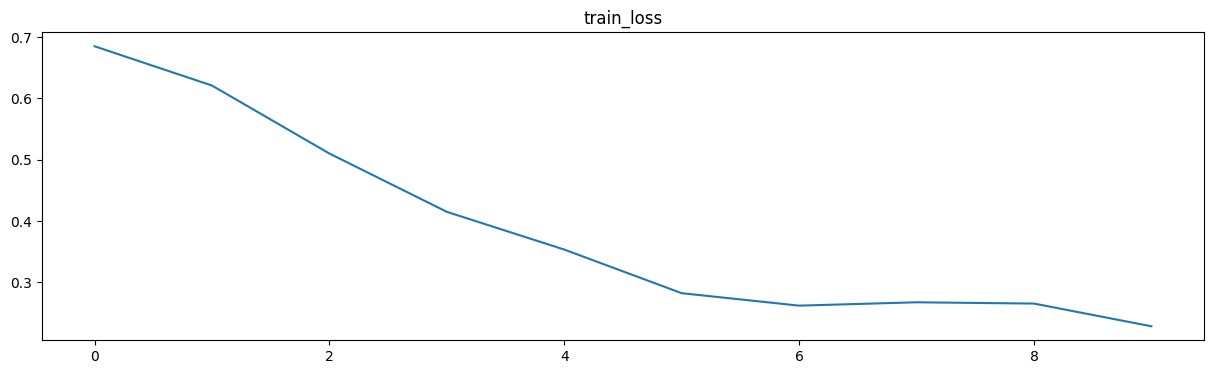

In [ ]:
max_epochs = 10
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    patience=3,
    threshold=1e-4,
    mode="min"
)
results = train(model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6375000178813934

Ответьте себе на вопрос: не переобучается ли моя модель?

Модель переобучается, но не значитально.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i 2X_iY_i}{\sum_i(X_i+Y_i)}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred[:, 0].contiguous().view(-1)
    y_true = y_true[:, 0].contiguous().view(-1)
    intersection = (y_pred * y_true).sum()
    dsc = (2. * intersection + smooth) / (
        y_pred.sum() + y_true.sum() + smooth
    )
    return 1. - dsc

Проводим тестирование:

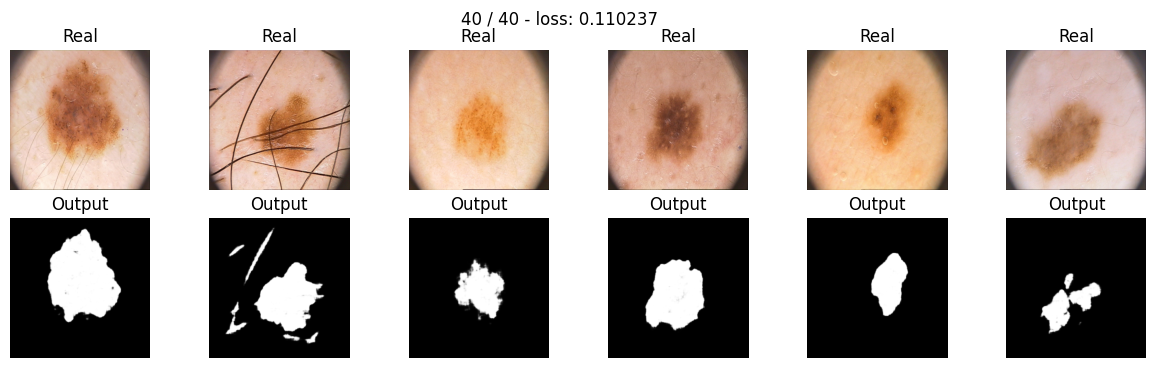

loading best model state


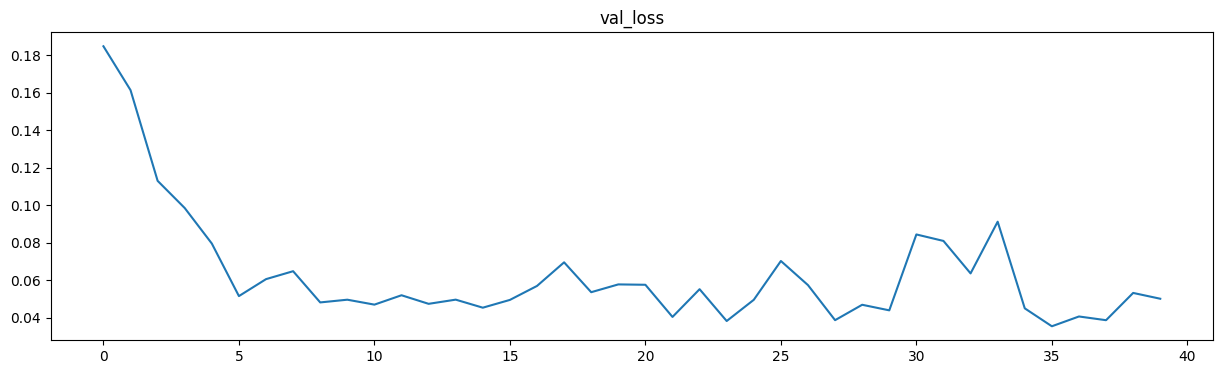

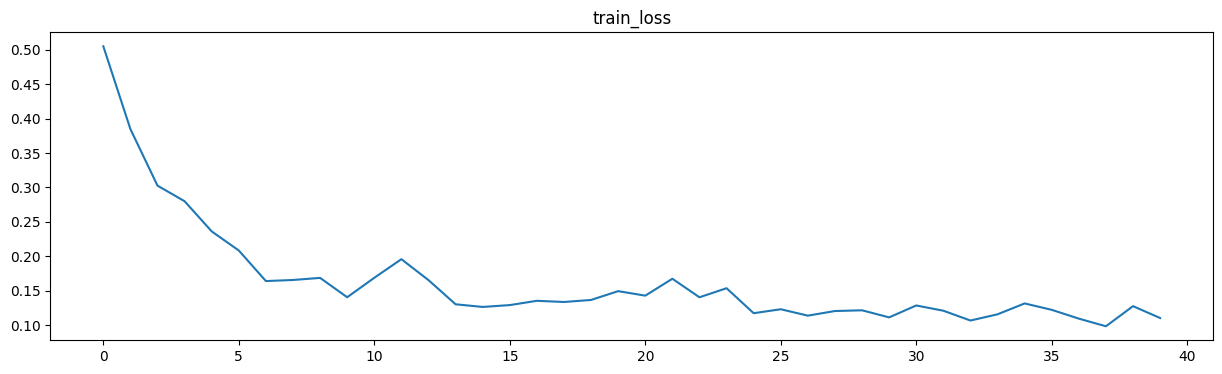

([0.1848500669002533,
  0.1614496409893036,
  0.1130734384059906,
  0.09856447577476501,
  0.07962638139724731,
  0.05160053074359894,
  0.06064411997795105,
  0.0648752897977829,
  0.04822574555873871,
  0.04967507719993591,
  0.047046467661857605,
  0.05204617977142334,
  0.0474729984998703,
  0.04970371723175049,
  0.04541708528995514,
  0.04956577718257904,
  0.05701133608818054,
  0.06960627436637878,
  0.05367828905582428,
  0.05783209204673767,
  0.05763836205005646,
  0.04048524796962738,
  0.055275559425354004,
  0.03830477595329285,
  0.049620598554611206,
  0.07032114267349243,
  0.05745759606361389,
  0.038760051131248474,
  0.046970248222351074,
  0.04399588704109192,
  0.08447897434234619,
  0.0810212790966034,
  0.06370267271995544,
  0.09128294885158539,
  0.04506751894950867,
  0.03549937903881073,
  0.04072466492652893,
  0.03874368965625763,
  0.05328775942325592,
  0.05018910765647888],
 [0.5051742196083069,
  0.3848241865634918,
  0.3026306629180908,
  0.2799676358

In [ ]:
model_dice = SegNet().to(device)
import torch.optim as optim
max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.668749988079071

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred) + eps
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    focal_loss = -((1 - y_pred) ** gamma * y_real * y_pred.log() + (1-y_real)*(1-y_pred).log())
    return focal_loss.mean()

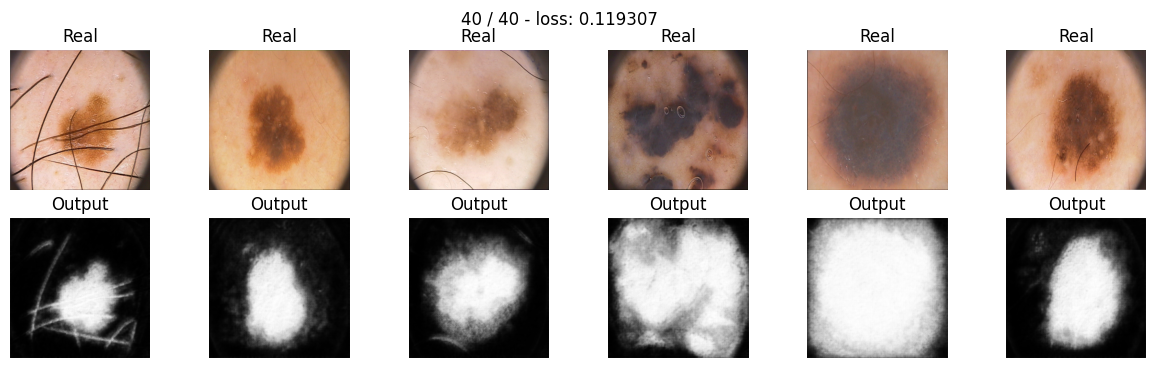

loading best model state


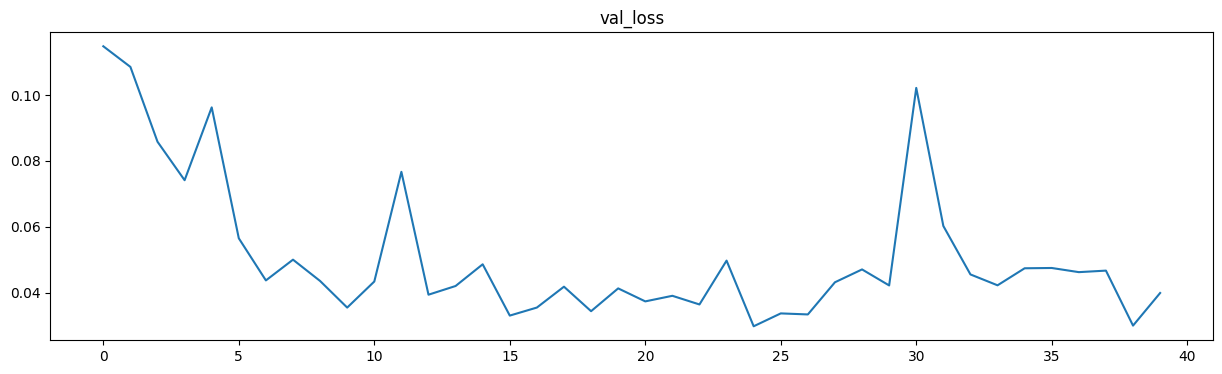

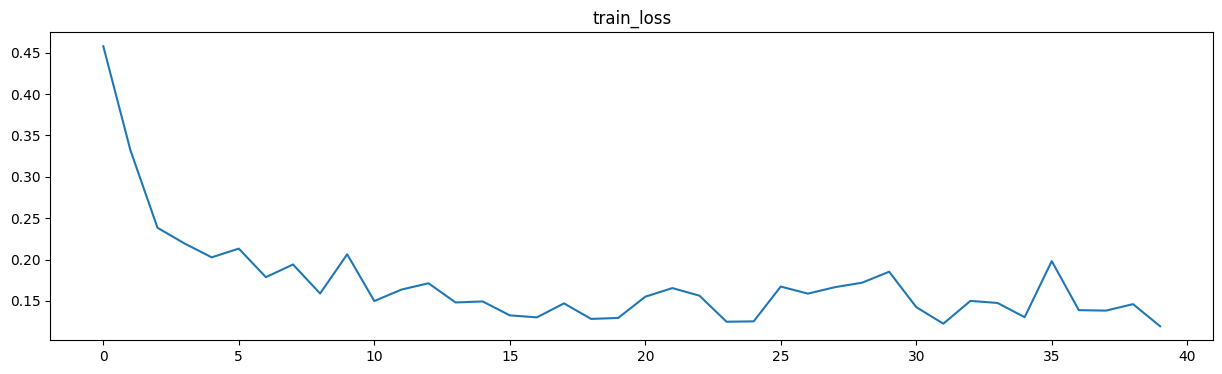

([0.11477749049663544,
  0.1085125058889389,
  0.08579326421022415,
  0.0741124376654625,
  0.09622232615947723,
  0.05647590756416321,
  0.04368598014116287,
  0.049986567348241806,
  0.043514229357242584,
  0.03543707728385925,
  0.0433485321700573,
  0.07665553689002991,
  0.039349012076854706,
  0.04198931157588959,
  0.048579245805740356,
  0.03300453722476959,
  0.03544436767697334,
  0.04178207367658615,
  0.03434205427765846,
  0.04126404970884323,
  0.03731708973646164,
  0.0390143096446991,
  0.03638368099927902,
  0.0496998056769371,
  0.02976013347506523,
  0.03366963937878609,
  0.03335607051849365,
  0.04312345013022423,
  0.04702192544937134,
  0.04215994477272034,
  0.10213495790958405,
  0.06020905077457428,
  0.045500822365283966,
  0.042199403047561646,
  0.047371745109558105,
  0.04746001958847046,
  0.04619729518890381,
  0.04665962606668472,
  0.029964148998260498,
  0.03986870497465134],
 [0.45770785212516785,
  0.3321397304534912,
  0.23835253715515137,
  0.2193

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.6906250417232513

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

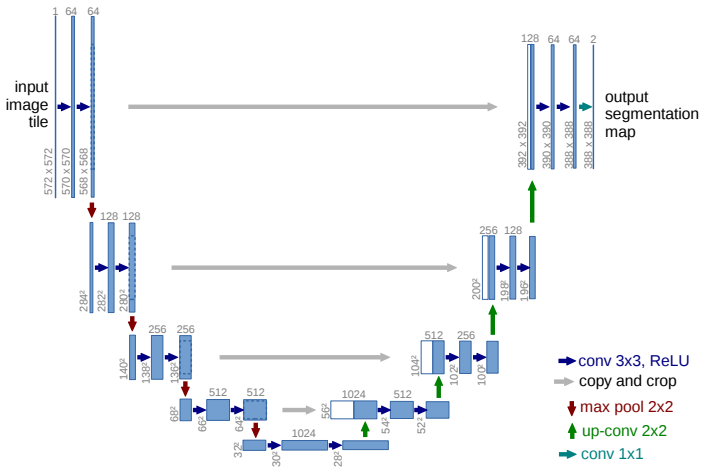

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.enc_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128


        self.enc_conv1_0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.enc_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64


        self.enc_conv2_0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.enc_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32


        self.enc_conv3_0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.enc_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        self.bottleneck_conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024)
        )
        self.bottleneck_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024)
        )

        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0_0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.dec_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )

        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1_0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.dec_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )

        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2_0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.dec_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )

        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3_0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.dec_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.dec_conv3_2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)


    def forward(self, x):
        # encoder
        e0_0 = F.relu(self.enc_conv0_1(F.relu(self.enc_conv0_0(x))))
        e0_1 = self.pool0(e0_0) # 256 -> 128
        e1_0 = F.relu(self.enc_conv1_1(F.relu(self.enc_conv1_0(e0_1))))
        e1_1 = self.pool1(e1_0) # 128 -> 64
        e2_0 = F.relu(self.enc_conv2_1(F.relu(self.enc_conv2_0(e1_1))))
        e2_1 = self.pool2(e2_0) # 64 -> 32
        e3_0 = F.relu(self.enc_conv3_1(F.relu(self.enc_conv3_0(e2_1))))
        e3_1 = self.pool3(e3_0) # 32 -> 16

        # bottleneck
        b = F.relu(self.bottleneck_conv_1(F.relu(self.bottleneck_conv_0(e3_1))))

        # decoder
        d0 = F.relu(self.dec_conv0_1(F.relu(self.dec_conv0_0(torch.cat((e3_0, self.upsample0(b)), dim=1)))))
        d1 = F.relu(self.dec_conv1_1(F.relu(self.dec_conv1_0(torch.cat((e2_0, self.upsample1(d0)), dim=1)))))
        d2 = F.relu(self.dec_conv2_1(F.relu(self.dec_conv2_0(torch.cat((e1_0, self.upsample2(d1)), dim=1)))))
        d3 = self.dec_conv3_2(F.relu(self.dec_conv3_1(F.relu(self.dec_conv3_0(torch.cat((e0_0, self.upsample3(d2)), dim=1))))))  # no activation
        return d3

In [ ]:
unet_model_bce = UNet().to(device)

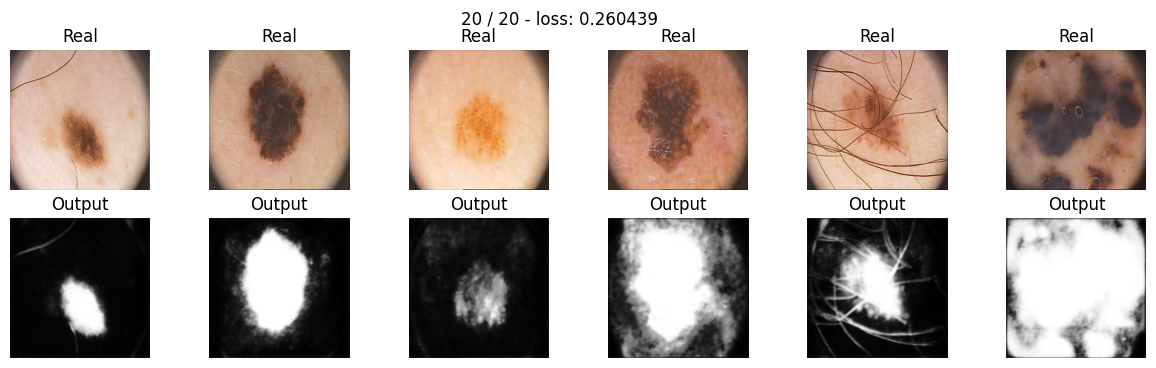

loading best model state


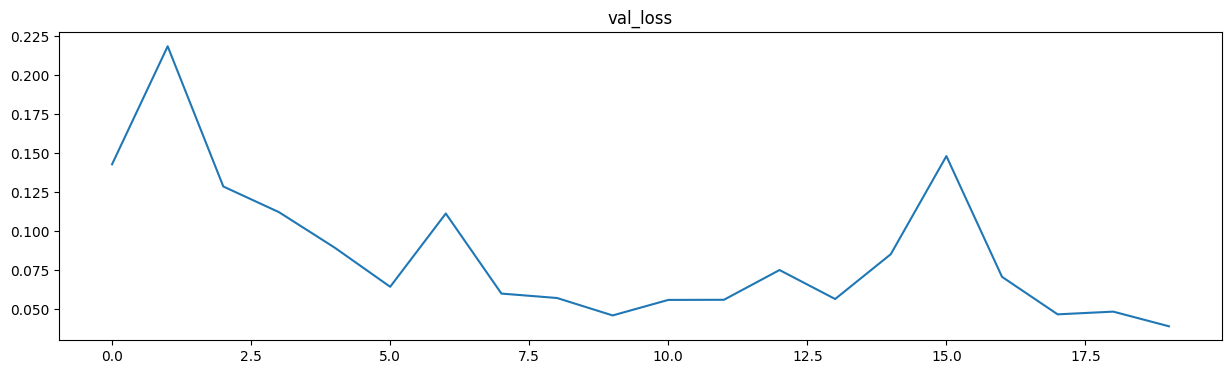

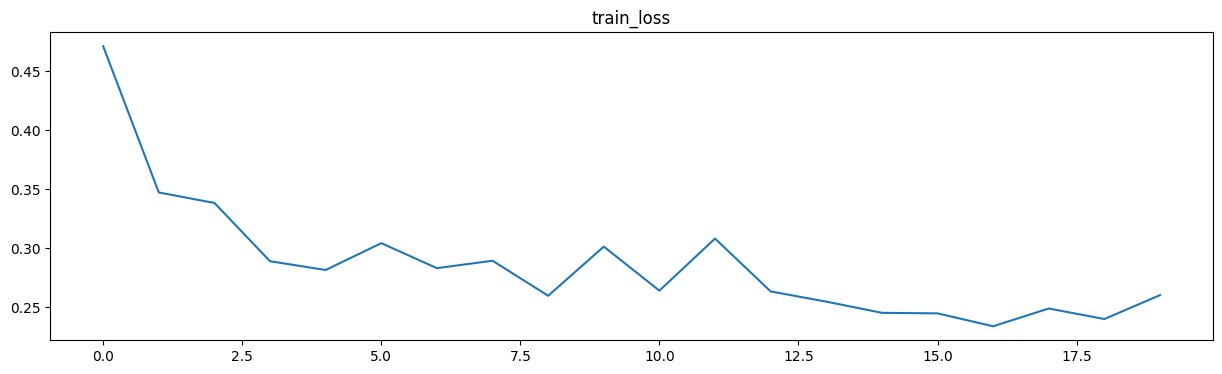

([0.14295262098312378,
  0.2185107171535492,
  0.12874183058738708,
  0.11232011020183563,
  0.08964718878269196,
  0.06452903896570206,
  0.1114349365234375,
  0.06018298864364624,
  0.057345375418663025,
  0.0461827777326107,
  0.05612063780426979,
  0.05620074272155762,
  0.07525375485420227,
  0.056701548397541046,
  0.08538197726011276,
  0.14819222688674927,
  0.07089675962924957,
  0.046880148351192474,
  0.048624735325574875,
  0.03924259543418884],
 [0.47104212641716003,
  0.34732121229171753,
  0.3384508490562439,
  0.2891432046890259,
  0.28172382712364197,
  0.30441856384277344,
  0.2832717001438141,
  0.28955453634262085,
  0.25992417335510254,
  0.301491916179657,
  0.2642533779144287,
  0.3083060383796692,
  0.2635740339756012,
  0.25493091344833374,
  0.2454725056886673,
  0.245005801320076,
  0.23408791422843933,
  0.2491294890642166,
  0.24021655321121216,
  0.2604391872882843],
 [0.0,
  0.34843750298023224,
  0.0,
  0.028125000186264515,
  0.06718750298023224,
  0.25

In [ ]:
train(unet_model_bce, optim.Adam(unet_model_bce.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model_bce, iou_pytorch, data_val)

0.6156250014901161

Теперь проверьте модель UNet c функцией потерь FocalLoss.

In [ ]:
unet_model_FL = UNet().to(device)

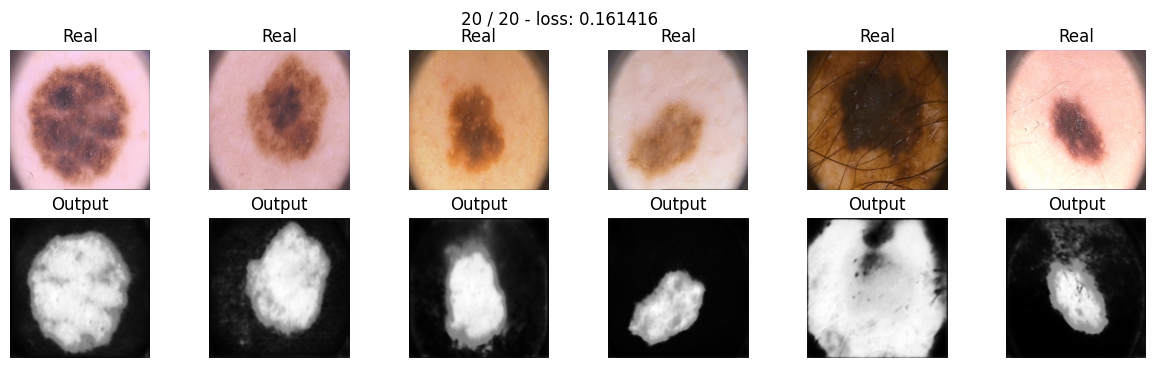

loading best model state


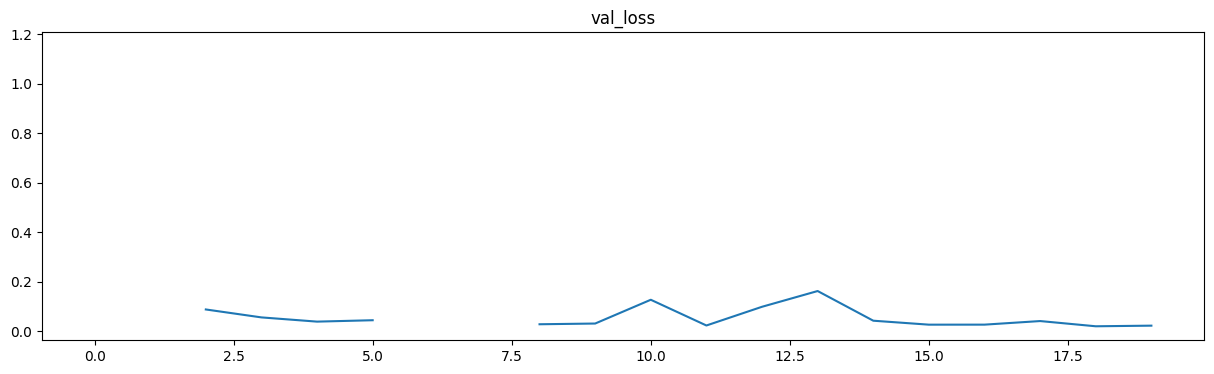

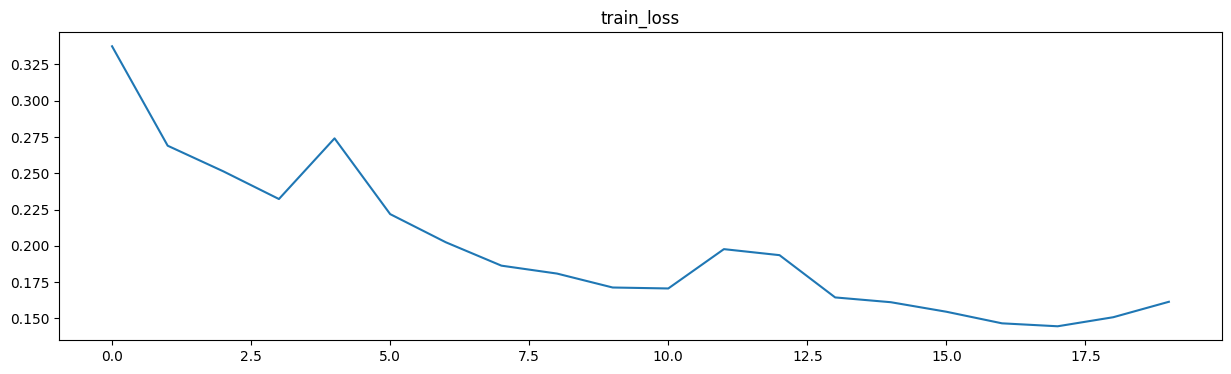

([1.1516834497451782,
  nan,
  0.08856207877397537,
  0.05648138001561165,
  0.03942479193210602,
  0.04506786912679672,
  nan,
  nan,
  0.028788551688194275,
  0.031709302216768265,
  0.12775446474552155,
  0.023802530020475388,
  0.09939350187778473,
  0.16300135850906372,
  0.04315049201250076,
  0.027144789695739746,
  0.027248788625001907,
  0.041709087789058685,
  0.020624149590730667,
  0.02313416451215744],
 [0.3374885320663452,
  0.26896795630455017,
  0.2513149380683899,
  0.23222579061985016,
  0.2740365266799927,
  0.22182297706604004,
  0.20242781937122345,
  0.1863093078136444,
  0.18085093796253204,
  0.17125441133975983,
  0.170591339468956,
  0.197691410779953,
  0.19354411959648132,
  0.16441933810710907,
  0.16112354397773743,
  0.15455137193202972,
  0.1465631127357483,
  0.14453351497650146,
  0.15077297389507294,
  0.16141553223133087],
 [0.1687500039115548,
  0.057812499813735485,
  0.018750000395812094,
  0.05312500149011612,
  0.2968750074505806,
  0.2468750067

In [ ]:
train(unet_model_FL, optim.Adam(unet_model_FL.parameters()), focal_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model_FL, iou_pytorch, data_val)

0.6343749910593033

Сделайте вывод, какая из моделей лучше.

**Общий вывод для модели Segnet**

Самые лучшие показатели на тестовых данных с функцией потерь Focal loss

**Общий вывод для модели UNet**

Cамый высокий IOU получился с функцией потерь Focal loss